## Stock Market Price Prediction via Logistic Regression

#### Author : Han Yu 

#### TL;DR
* Data: [Yahoo! Finance Market Data Downloader](https://pypi.org/project/yfinance/) 
* Methdology: using a very simple **logistic regression** to predict the next day's stock **movement** 

### Import Library

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

# Finance 
import talib as ta
import yfinance as yf

# Machine Learning 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

# Plotting 
import matplotlib.pyplot as plt

# Utils 
import os

### Default Setting

In [2]:
plt.rcParams['figure.figsize'] = [27.0, 9.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

In [3]:
STOCK_SYMBOL = 'AMZN'
START_DATE = '2010-01-01'
END_DATE = '2021-04-01'

### Import and Explore Data

In [4]:
df = pdr.get_data_yahoo(STOCK_SYMBOL, START_DATE, END_DATE )
df = df.dropna()
df.reset_index(inplace=True)

In [5]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
1,2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2,2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
3,2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
4,2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004


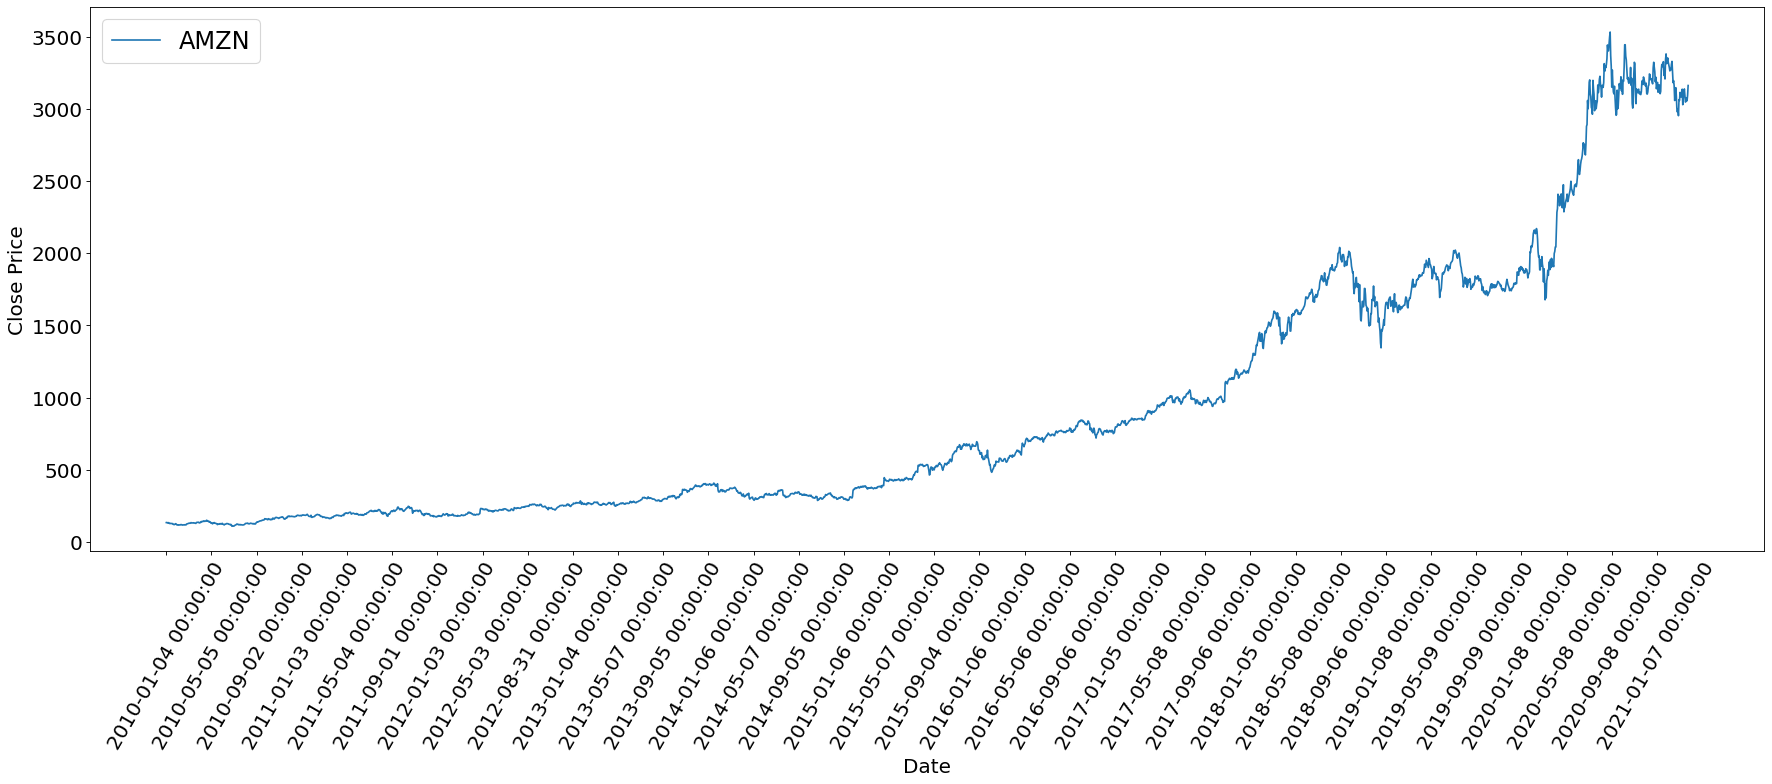

In [6]:
plt.plot(range(df.shape[0]),df['Close'], label= STOCK_SYMBOL)
plt.xticks(range(0,df.shape[0],28*3),df['Date'].loc[::28*3],rotation=60)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc=0)
plt.show()

### Define Features

In [7]:
df['Return_PCT'] = df['Close'].shift(1).pct_change().values
df['Return_PCT_MA'] = df['Return_PCT'].rolling(2).mean()
df['Activity_PCT'] = df['Volume'].shift(1).pct_change().values
df['Activity_PCT_MA'] = df['Activity_PCT'].rolling(2).mean()
df['Open-Close'] = (df['Open'].shift(1)-df['Close'].shift(2))/df['Close'].shift(2)
df = df.dropna()

In [8]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Return_PCT,Return_PCT_MA,Activity_PCT,Activity_PCT_MA,Open-Close
3,2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000,-0.018116,-0.006108,-0.189010,-0.012136,-0.000668
4,2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004,-0.017013,-0.017564,0.536496,0.173743,-0.001815
5,2010-01-11,132.800003,129.210007,132.619995,130.309998,8779400,130.309998,0.027077,0.005032,-0.108765,0.213866,0.004308
6,2010-01-12,129.820007,126.550003,128.990005,127.349998,9096300,127.349998,-0.024041,0.001518,-0.106922,-0.107844,-0.006741
7,2010-01-13,129.710007,125.750000,127.900002,129.110001,10723200,129.110001,-0.022715,-0.023378,0.036096,-0.035413,-0.010130


In [9]:
features = ['Return_PCT_MA', 'Activity_PCT_MA', 'Open-Close']
X = np.array(df[features])
df['delta_of_close_next_day'] = df['Adj Close'].shift(-1) - df['Adj Close']
y = np.where(df['delta_of_close_next_day'] > 0.0,1.0,-1.0)

### Split the Dataset for Training and Testing 

In [10]:
split = int(0.8*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

### Build Model 

In [11]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

### Prediction of Next Day's Stock Movement via Logistic Regression

In [12]:
probability = model.predict_proba(X_test)
predicted = model.predict(X_test)

### Evaluate Model

#### Confusion Matrix

In [13]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 21 237]
 [ 20 288]]


#### Classification Report

In [14]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

        -1.0       0.51      0.08      0.14       258
         1.0       0.55      0.94      0.69       308

    accuracy                           0.55       566
   macro avg       0.53      0.51      0.42       566
weighted avg       0.53      0.55      0.44       566



#### Cross-Validation

In [15]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.53710247 0.51943463 0.56537102 0.49469965 0.5335689  0.55123675
 0.55477032 0.55123675 0.52836879 0.52836879]
0.5364158083352129


### Create Traing Strategy Using the Model

In [16]:
df_pred = pd.DataFrame()
df_pred['Date']= df[split:]['Date']
df_pred['Close']= df[split:]['Close']
df_pred['Predicted_Signal'] = model.predict(X_test)
df_pred['Actual_Daily_Returns'] = df[split:]['Close'].pct_change().values
df_pred['Cumulative_Actual_Daily_Returns'] = (1 + df_pred['Actual_Daily_Returns']).cumprod()-1

In [17]:
df_pred.tail()

,Date,Close,Predicted_Signal,Actual_Daily_Returns,Cumulative_Actual_Daily_Returns
2826,2021-03-26,3052.030029,1.0,0.001894,1.034307
2827,2021-03-29,3075.729980,1.0,0.007765,1.050104
2828,2021-03-30,3055.290039,1.0,-0.006646,1.036480
2829,2021-03-31,3094.080078,1.0,0.012696,1.062335
2830,2021-04-01,3161.000000,1.0,0.021628,1.106940


In [18]:
df_pred['Strategy_Daily_Returns'] = df_pred['Actual_Daily_Returns']* df_pred['Predicted_Signal'].shift(1)
df_pred['Cumulative_Strategy_Daily_Returns'] = (1 + df_pred['Strategy_Daily_Returns']).cumprod()-1

In [19]:
df_pred.reset_index(inplace=True)
df_pred.tail()

,index,Date,Close,Predicted_Signal,Actual_Daily_Returns,Cumulative_Actual_Daily_Returns,Strategy_Daily_Returns,Cumulative_Strategy_Daily_Returns
561,2826,2021-03-26,3052.030029,1.0,0.001894,1.034307,0.001894,0.552978
562,2827,2021-03-29,3075.729980,1.0,0.007765,1.050104,0.007765,0.565038
563,2828,2021-03-30,3055.290039,1.0,-0.006646,1.036480,-0.006646,0.554637
564,2829,2021-03-31,3094.080078,1.0,0.012696,1.062335,0.012696,0.574375
565,2830,2021-04-01,3161.000000,1.0,0.021628,1.106940,0.021628,0.608426


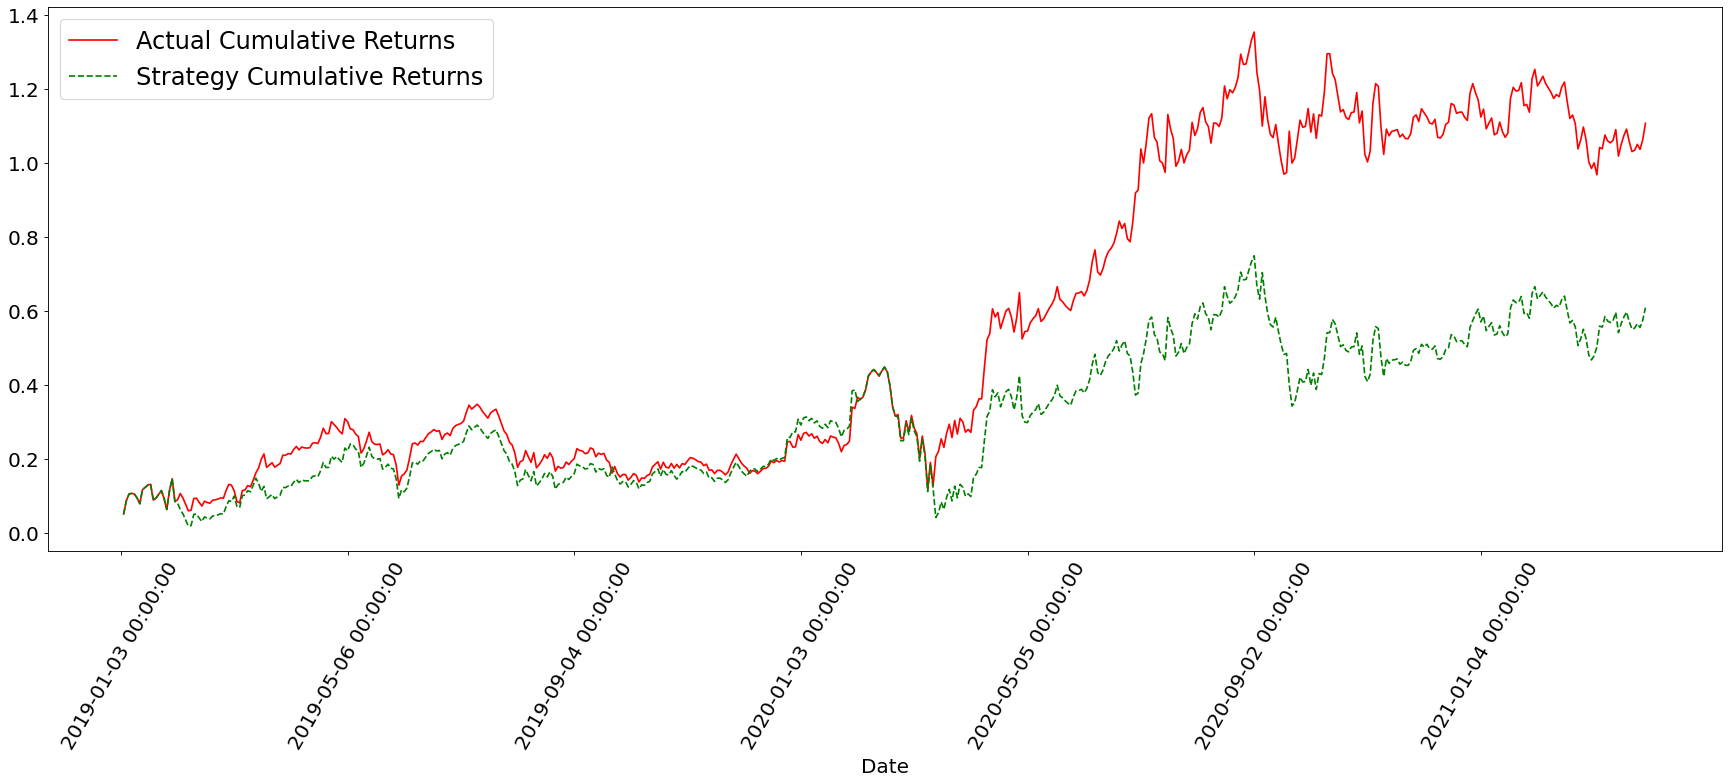

In [20]:
plt.figure()
plt.plot(df_pred['Cumulative_Actual_Daily_Returns'], color='r', label = 'Actual Cumulative Returns')
plt.plot(df_pred['Cumulative_Strategy_Daily_Returns'], color='g', linestyle ='--', label = 'Strategy Cumulative Returns')
plt.xticks(range(0,len(df_pred),28*3),df_pred['Date'].loc[::28*3],rotation=60)
plt.xlabel('Date')
plt.legend()
plt.show()